In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_excel("C:\\Users\\s\\Desktop\\Dersler\\Data Informatics\\DI502\\Github\\Electricity_Consmption_EPIAS_data.xlsx")

dates_dt = pd.to_datetime(df.Tarih, format='%d.%m.%Y')
    
df.Tarih = dates_dt.copy()
df = df.sort_values("Tarih")

In [3]:
df['year']=df['Tarih'].dt.year 
df['month']=df['Tarih'].dt.month
df['day']=df['Tarih'].dt.day
df['season']=df['Tarih'].dt.quarter
df['week']=df['Tarih'].dt.isocalendar().week
df['dayofweek']=df['Tarih'].dt.dayofweek
df['hour']= df.Saat.astype("str").apply(lambda x: x[:2]).astype("int")

df = df.sort_values(["year","month","day","hour"])

target = "Tüketim Miktarı (MWh)"

df[target] =  pd.Series([item.replace(".", "").replace(",",".") for item in df.loc[:,target]]).astype("float64")

In [4]:
train = df[df.Tarih <= "2023-09-30"].reset_index(drop=True).copy()
test = df[df.Tarih > "2023-09-30"].reset_index(drop=True).copy()

In [26]:
#SARIMA
model = ARIMA(train["Tüketim Miktarı (MWh)"], order=(1, 0, 1),seasonal_order=(0,1,0,24))
model_fit = model.fit()

prediction_arima = model_fit.get_forecast(test.shape[0]).predicted_mean

# PERFORMANCE
rmse = mean_squared_error(test["Tüketim Miktarı (MWh)"], prediction_arima.reset_index(drop=True), squared=False)
r2 = r2_score(test["Tüketim Miktarı (MWh)"], prediction_arima.reset_index(drop=True))
print("r2:",r2, "rmse:", rmse)

r2: 0.6583787504964393 rmse: 2616.5256999943754


In [25]:
best_params = {"learning_rate": 0.11867001834319307,
"max_depth" : 6, 
"n_estimators": 474,
"num_leaves": 29,
"reg_alpha": 50,
"reg_lambda": 97,
"subsample": 0.8}

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 17520, number of used features: 7
[LightGBM] [Info] Start training from score 37127.426340
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 17520, number of used features: 7
[LightGBM] [Info] Start training from score 37127.426340
Base  r2: 0.9414566883958938 rmse: 1083.1564971705934
Tuned  r2: 0.9640585951580282 rmse: 848.691965173023


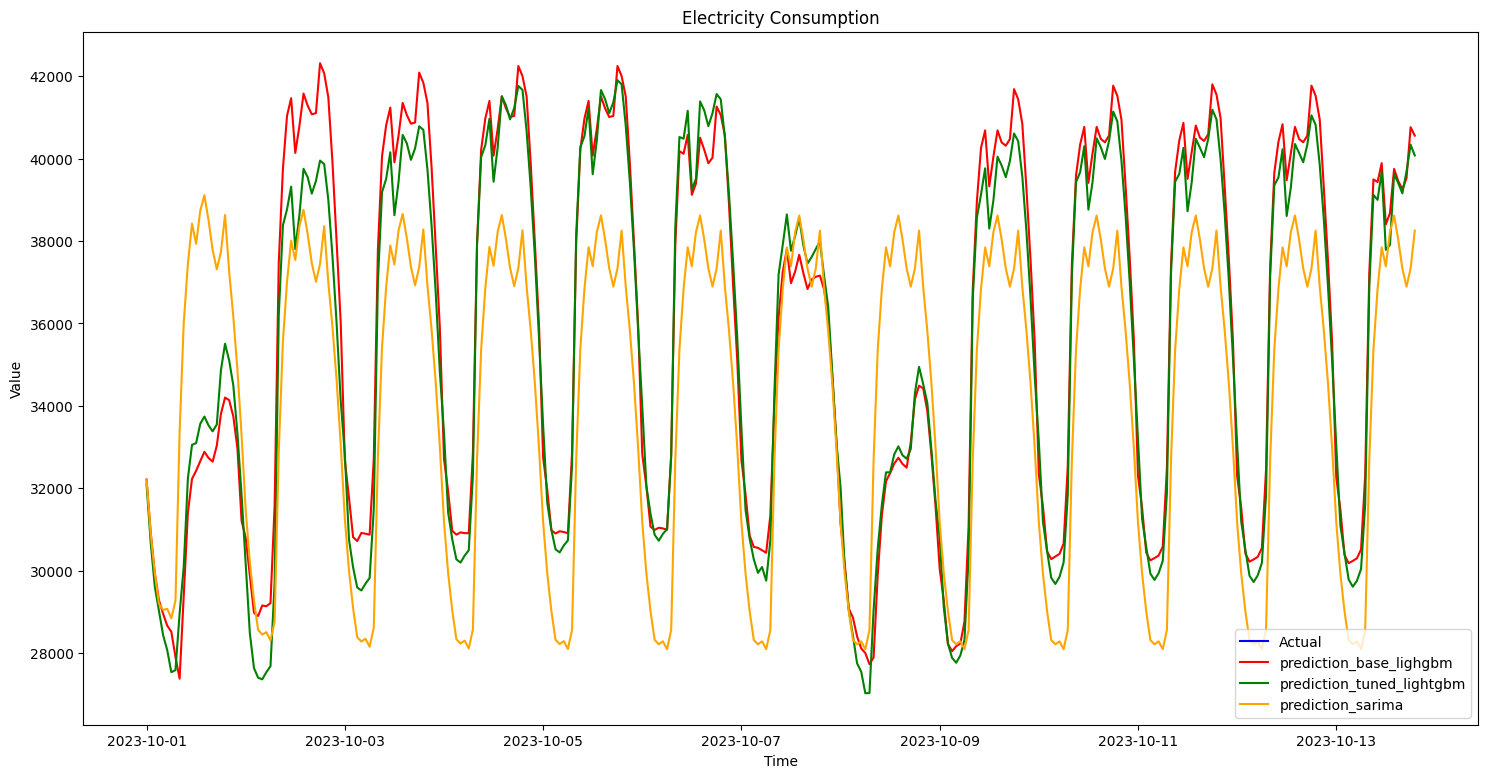

In [49]:
x_train = train.iloc[:,-7:]
x_test = test.iloc[:,-7:]
y_train = train.loc[:,target]
y_test = test.loc[:,target]

# Base Lightgbm
eval_set = [(x_test,y_test)]
basic_model = LGBMRegressor(random_state=42,verbose=1)
basic_model.fit(x_train, y_train,eval_set=eval_set)

# Tuned Lightgbm
tuned_model = LGBMRegressor(random_state=42,verbose=1,**best_params)
tuned_model.fit(x_train, y_train,eval_set=eval_set)

y_predicted = pd.Series(basic_model.predict(x_test))
y_predicted_tuned = pd.Series(tuned_model.predict(x_test))

rmse = mean_squared_error(y_test, y_predicted, squared=False)
r2 = r2_score(y_test, y_predicted)
print("Base ","r2:",r2, "rmse:", rmse)

index_label = (test.Tarih.astype("str") + " " +   test.Saat.astype("str")).astype("datetime64[ns]")

y_predicted.index = index_label

rmse = mean_squared_error(y_test, y_predicted_tuned, squared=False)
r2 = r2_score(y_test, y_predicted_tuned)
print("Tuned ","r2:",r2, "rmse:", rmse)

y_predicted_tuned.index = index_label

prediction_arima.index = index_label

actual = test["Tüketim Miktarı (MWh)"].reindex(index_label)

plt.figure(figsize=(18, 9))
plt.plot(actual, label='Actual', color='blue')
plt.plot(y_predicted, label='prediction_base_lighgbm', color='red')
plt.plot(y_predicted_tuned, label='prediction_tuned_lightgbm', color='green')
plt.plot(prediction_arima, label='prediction_sarima', color='orange')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Electricity Consumption')
plt.legend(loc='lower right')
plt.show()